# Speech Emotion Recognition

## Prerequisites

https://huggingface.co/docs/transformers/tasks/audio_classification#audio-classification

In [ ]:
!pip install -q transformers datasets wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.9 MB/s eta 0:00:00


In [ ]:
!pip install -q --upgrade datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 19.0 MB/s eta 0:00:00


In [ ]:
!pip install -q accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 3.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
!nvidia-smi

Wed May  8 05:11:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import wandb

wandb.login(key='')

## Load dataset from hugging face hub

In [ ]:
from huggingface_hub import login

login(token="")

In [ ]:
from datasets import load_dataset, Audio

iemocap_audio = load_dataset("Zahra99/IEMOCAP_Audio")

Generating session1 split:   0%|          | 0/1085 [00:00<?, ? examples/s]

Generating session2 split:   0%|          | 0/1023 [00:00<?, ? examples/s]

Generating session3 split:   0%|          | 0/1151 [00:00<?, ? examples/s]

Generating session4 split:   0%|          | 0/1031 [00:00<?, ? examples/s]

Generating session5 split:   0%|          | 0/1241 [00:00<?, ? examples/s]

In [ ]:
iemocap_audio

DatasetDict({
    session1: Dataset({
        features: ['audio', 'label'],
        num_rows: 1085
    })
    session2: Dataset({
        features: ['audio', 'label'],
        num_rows: 1023
    })
    session3: Dataset({
        features: ['audio', 'label'],
        num_rows: 1151
    })
    session4: Dataset({
        features: ['audio', 'label'],
        num_rows: 1031
    })
    session5: Dataset({
        features: ['audio', 'label'],
        num_rows: 1241
    })
})

In [ ]:
iemocap_audio["session1"].features

{'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'label': ClassLabel(names=['ang', 'hap', 'neu', 'sad'], id=None)}

For path we have only the file name not all of the directory, although we have full directory before we create hugging face dataset.

In [ ]:
iemocap_audio["session1"][0]

{'audio': {'path': 'Ses01M_impro01_F000.wav',
  'array': array([ 0.00543213,  0.00488281,  0.00537109, ...,  0.0017395 ,
         -0.00650024, -0.01904297]),
  'sampling_rate': 16000},
 'label': 0}

In [ ]:
labels = iemocap_audio["session1"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [ ]:
id2label[str(0)]

'ang'

## Calculate duration of data in each session

In [ ]:
sampling_rate = iemocap_audio["session1"][0]["audio"]["sampling_rate"]
session1_duration = [(len(iemocap_audio["session1"][i]["audio"]["array"])/sampling_rate, "session1") for i in range(len(iemocap_audio["session1"]))]
session2_duration = [(len(iemocap_audio["session2"][i]["audio"]["array"])/sampling_rate, "session2") for i in range(len(iemocap_audio["session2"]))]
session3_duration = [(len(iemocap_audio["session3"][i]["audio"]["array"])/sampling_rate, "session3") for i in range(len(iemocap_audio["session3"]))]
session4_duration = [(len(iemocap_audio["session4"][i]["audio"]["array"])/sampling_rate, "session4") for i in range(len(iemocap_audio["session4"]))]
session5_duration = [(len(iemocap_audio["session5"][i]["audio"]["array"])/sampling_rate, "session5") for i in range(len(iemocap_audio["session5"]))]

In [ ]:
session_duration = session1_duration + session2_duration + session3_duration + session4_duration + session5_duration

# Define column names
columns = ['Duration', 'Session']

# Create DataFrame
df = pd.DataFrame(session_duration, columns=columns)

In [ ]:
df.head()

Duration   Session
0  1.689938  session1
1  2.050000  session1
2  2.479938  session1
3  3.419938  session1
4  3.736000  session1

In [ ]:
print(f'data frame shape : {df.shape}')
print(f'max duration in dataset : {max(df.Duration)} seconds')

data frame shape : (5531, 2)
max duration in dataset : 34.13875 seconds


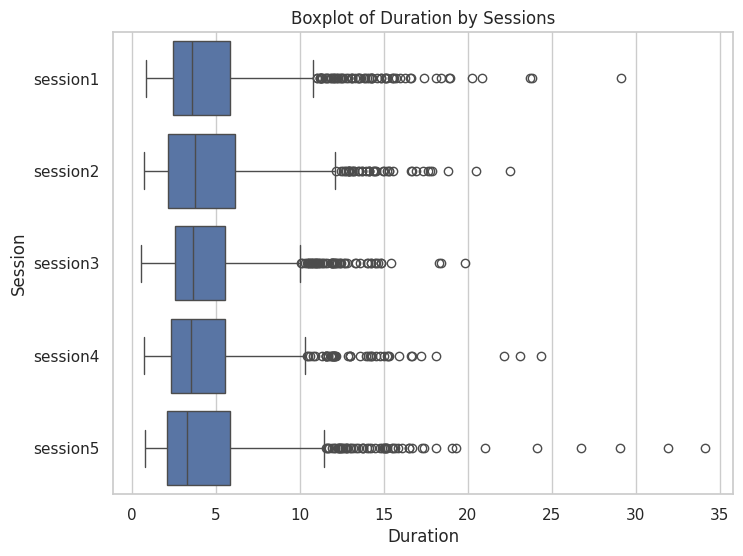

In [ ]:
# Plot a boxplot
sns.set(style='whitegrid')
plt.figure(figsize=(8, 6))
sns.boxplot(x='Duration', y='Session', data=df)
plt.title('Boxplot of Duration by Sessions')
plt.show()

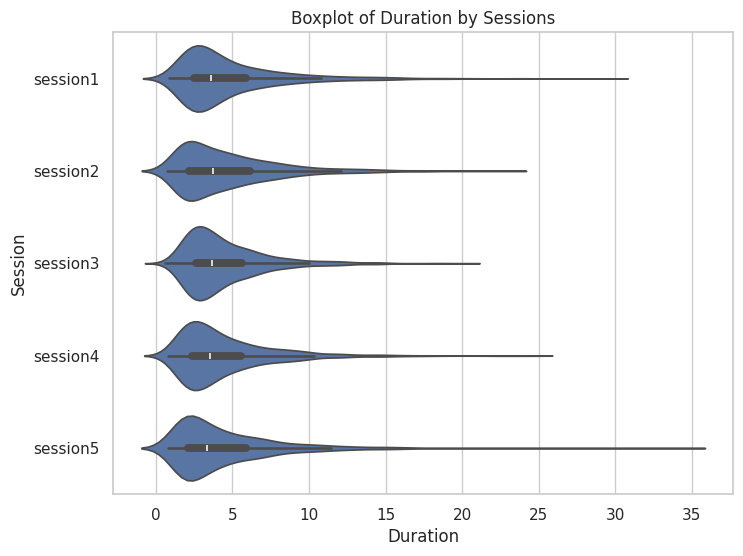

In [ ]:
# Plot a boxplot
sns.set(style='whitegrid')
plt.figure(figsize=(8, 6))
sns.violinplot(x="Duration", y="Session", data=df)
plt.title('Boxplot of Duration by Sessions')
plt.show()

As it is clear in the above violin plot, density of the plots for each session are large between o and 5. So, logic would dictate that selecting 5 as the max-length (=maximum audio duration) can be wise. Choosing a lower value can result in the loss of a significant portion of the dataset. On the other hand, choosing higher value, can add complexity to our preprocess function and the trianing process takes too much.




## Split train, valid and test

Let's split trian, valid and test dataset. We use the first three sessions of the IEMOCAP dataset as trainin set, the fourth session as validation set and fifth session as the test set. Then we should put these splits in one `DataDict` and create a new dataset with them.

In [ ]:
from datasets import concatenate_datasets

iemocap_train = concatenate_datasets([iemocap_audio['session1'], iemocap_audio['session2'], iemocap_audio['session3']])
iemocap_valid = iemocap_audio['session4']
iemocap_test = iemocap_audio['session5']

In [ ]:
iemocap_train

Dataset({
    features: ['audio', 'label'],
    num_rows: 3259
})

In [ ]:
iemocap_train[1084]

{'audio': {'path': 'Ses01M_script01_1_F043.wav',
  'array': array([ 0.00128174,  0.00042725,  0.00018311, ..., -0.00402832,
         -0.00479126, -0.00427246]),
  'sampling_rate': 16000},
 'label': 0}

In [ ]:
iemocap_train[1085]

{'audio': {'path': 'Ses02F_script01_2_M001.wav',
  'array': array([-2.74658203e-04,  9.15527344e-05,  1.28173828e-03, ...,
          5.43212891e-03,  5.43212891e-03,  5.40161133e-03]),
  'sampling_rate': 16000},
 'label': 2}

### Show some audio file
Let's show the some audio files.

In [ ]:
import random
from IPython.display import Audio, display

idx_lst = [0, 1084, 1085, 2107, 2108, 3258]

for idx in idx_lst:
    example = iemocap_train[idx]
    audio = example["audio"]

    print(f'Utterance: {example["audio"]["path"]}')
    print(f'Label: {id2label[str(example["label"])]}')
    print(f'Shape: {audio["array"].shape}, sampling rate: {audio["sampling_rate"]}')
    display(Audio(audio["array"], rate=audio["sampling_rate"]))
    print()

Utterance: Ses01M_impro01_F000.wav
Label: ang
Shape: (27039,), sampling rate: 16000



Utterance: Ses01M_script01_1_F043.wav
Label: ang
Shape: (50416,), sampling rate: 16000



Utterance: Ses02F_script01_2_M001.wav
Label: neu
Shape: (50079,), sampling rate: 16000



Utterance: Ses02M_impro04_M022.wav
Label: sad
Shape: (50060,), sampling rate: 16000



Utterance: Ses03M_script01_2_F000.wav
Label: ang
Shape: (39749,), sampling rate: 16000



Utterance: Ses03M_impro03_M039.wav
Label: hap
Shape: (81949,), sampling rate: 16000


In [ ]:
iemocap_train["label"][:20]

[0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2]

In [ ]:
from datasets import DatasetDict
dataset = DatasetDict({
                    "train": iemocap_train,
                    "valid": iemocap_valid,
                    "test": iemocap_test
})

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 3259
    })
    valid: Dataset({
        features: ['audio', 'label'],
        num_rows: 1031
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 1241
    })
})

## Define needed functions

### Defining the performance metrics

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

### Defining Confusion matrix

In [ ]:
classes = ["ang", "hap", "neu", "sad"]

In [ ]:
def confusion_matrix(y_test, y_pred):
  labels = [i for i in range(len(list(set(y_test))))]
  df_cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), index = labels,
                columns = labels)
  plt.figure(figsize=(8,6))
  ax= plt.subplot()
  sns.heatmap(df_cm, annot=True, cmap="YlGnBu" ,fmt='g', ax=ax)
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  class_names= classes
  ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);
  plt.tight_layout()
  plt.show()

In [ ]:
def confusion_matrix_normalized(y_test, y_pred):
  labels = [i for i in range(len(list(set(y_test))))]
  df_cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred, normalize="true"), index = labels,
                columns = labels)
  plt.figure(figsize=(8,6))
  ax= plt.subplot()
  sns.heatmap(df_cm, annot=True, cmap="YlGnBu" ,fmt='g', ax=ax)
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  class_names= classes
  ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);
  plt.tight_layout()
  plt.show()

### Defining the int2label

In [ ]:
def inverse(idx):
  inv = {0: "ang",
         1: "hap",
         2: "neu",
         3: "sad"}
  return inv[idx]

### Defining data stamp function

In [ ]:
from datetime import datetime

def date_stamp():

  # Get the current date
  current_date = datetime.now()

  # Format the date as "YYYYMMDD"
  formatted_date = current_date.strftime("%Y%m%d_%H%M%S")

  return formatted_date

## Whisper 1 (whisper-tiny)(whiout considering max len)




### Load feature extractor

In [ ]:
from transformers import set_seed

set_seed(42)

In [ ]:
from transformers import AutoFeatureExtractor

model_checkpoint = "openai/whisper-tiny"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

In [ ]:
feature_extractor

WhisperFeatureExtractor {
  "chunk_length": 30,
  "feature_extractor_type": "WhisperFeatureExtractor",
  "feature_size": 80,
  "hop_length": 160,
  "n_fft": 400,
  "n_samples": 480000,
  "nb_max_frames": 3000,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "WhisperProcessor",
  "return_attention_mask": false,
  "sampling_rate": 16000
}

In [ ]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # there is no need for encoding label
    batch["label"] = batch["label"]
    return batch


In [ ]:
iemocap.column_names["train"]

['audio', 'label']

In [ ]:
encoded_iemocap_audio = iemocap.map(prepare_dataset, remove_columns="audio", num_proc=4)

In [ ]:
encoded_iemocap_audio

DatasetDict({
    train: Dataset({
        features: ['label', 'input_features'],
        num_rows: 3259
    })
    valid: Dataset({
        features: ['label', 'input_features'],
        num_rows: 1031
    })
    test: Dataset({
        features: ['label', 'input_features'],
        num_rows: 1241
    })
})

In [ ]:
encoded_iemocap_audio['train'][0]

{'label': 1,
 'input_features': [[0.4243883490562439,
   0.3921792507171631,
   0.2601354122161865,
   0.41285771131515503,
   0.3586781620979309,
   0.3181752562522888,
   0.48524487018585205,
   0.499445378780365,
   0.4349392056465149,
   0.5157755613327026,
   0.3697686791419983,
   0.26507794857025146,
   0.4284776449203491,
   0.26624369621276855,
   0.12277573347091675,
   0.32662320137023926,
   0.30575013160705566,
   0.3179091215133667,
   0.3678452968597412,
   0.35195255279541016,
   0.1549130082130432,
   0.2579531669616699,
   0.1983020305633545,
   0.02394801378250122,
   0.07177770137786865,
   0.3082776665687561,
   0.36633139848709106,
   0.29387420415878296,
   0.43945789337158203,
   0.222126305103302,
   0.38925302028656006,
   0.48330408334732056,
   0.2291894555091858,
   0.3428908586502075,
   0.4298374056816101,
   -0.19424951076507568,
   0.39165353775024414,
   0.35362011194229126,
   0.07067817449569702,
   0.3571345806121826,
   0.4166337847709656,
   0.334

In [ ]:
len(encoded_iemocap_audio['train'][0]['input_features'])

80

### Fine-Tunning Transformer

In [ ]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained( model_checkpoint, num_labels=num_labels, label2id=label2id, id2label=id2label)

Some weights of the model checkpoint at openai/whisper-tiny were not used when initializing WhisperForAudioClassification: ['model.decoder.layers.2.fc2.weight', 'model.decoder.layers.2.encoder_attn.out_proj.weight', 'model.decoder.layers.0.self_attn.v_proj.weight', 'model.decoder.layers.1.encoder_attn_layer_norm.weight', 'model.decoder.layers.3.self_attn.q_proj.weight', 'model.decoder.layers.3.fc2.weight', 'model.decoder.layers.0.fc1.bias', 'model.decoder.embed_tokens.weight', 'model.decoder.layers.1.self_attn.out_proj.weight', 'model.decoder.layers.1.final_layer_norm.bias', 'model.decoder.layers.0.encoder_attn.v_proj.bias', 'model.decoder.layers.0.encoder_attn_layer_norm.bias', 'model.decoder.layers.0.encoder_attn.q_proj.weight', 'model.decoder.layers.3.self_attn_layer_norm.bias', 'model.decoder.layers.1.encoder_attn.k_proj.weight', 'model.decoder.embed_positions.weight', 'model.decoder.layers.2.self_attn.out_proj.bias', 'model.decoder.layers.1.encoder_attn.out_proj.weight', 'model.de

In [ ]:
model

WhisperForAudioClassification(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 384, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(384, 384, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 384)
    (layers): ModuleList(
      (0-3): 4 x WhisperEncoderLayer(
        (self_attn): WhisperAttention(
          (k_proj): Linear(in_features=384, out_features=384, bias=False)
          (v_proj): Linear(in_features=384, out_features=384, bias=True)
          (q_proj): Linear(in_features=384, out_features=384, bias=True)
          (out_proj): Linear(in_features=384, out_features=384, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (final_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affi

### Training the model

In [ ]:
batch_size = 8
training_args = TrainingArguments(output_dir=f"{model_checkpoint}-finetuned-iemocap4",
                                  evaluation_strategy="epoch",
                                  learning_rate=3e-5,
                                  per_device_train_batch_size=batch_size,
                                  gradient_accumulation_steps=1, ### ??
                                  per_device_eval_batch_size=batch_size,
                                  num_train_epochs=5,
                                  warmup_ratio=0.1, ###?
                                  logging_steps=10,
                                  load_best_model_at_end=False,
                                  metric_for_best_model="accuracy", ###?
                                  push_to_hub=True,
                                  hub_private_repo=True,
                                  report_to = 'wandb',
                                  run_name = 'Whisper-fine-tuning'                                  )

In [ ]:
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=encoded_iemocap_audio["train"],
                  eval_dataset=encoded_iemocap_audio["valid"],
                  tokenizer=feature_extractor,
                  compute_metrics=compute_metrics)

Cloning https://huggingface.co/Zahra99/whisper-tiny-finetuned-iemocap4 into local empty directory.


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
trainer.train()

TrainOutput(global_step=2040, training_loss=0.6268710999220025, metrics={'train_runtime': 3723.9967, 'train_samples_per_second': 4.376, 'train_steps_per_second': 0.548, 'total_flos': 1.814291765856e+17, 'train_loss': 0.6268710999220025, 'epoch': 5.0})

<img style="float: left;" src='https://drive.google.com/uc?id=15hxkL2mXXDc81Snc4PAQiOuxFEqfEkXL' width="500" height="300">
<!-- <br> -->
<img style="float: right;" src='https://drive.google.com/uc?id=1MbWA0G6NNe8ly7XBziM57lxWZqJ844G_' width="500" height="300">
<!-- <br> -->
<img src='https://drive.google.com/uc?id=19P_T1kmtiBfasmNySqRQnKLkZzBMg7ai' width="500" height="300">

In [ ]:
trainer.push_to_hub("Zahra99/whisper-tiny-finetuned-iemocap4")

Upload file pytorch_model.bin:   0%|          | 1.00/31.7M [00:00<?, ?B/s]

To https://huggingface.co/Zahra99/whisper-tiny-finetuned-iemocap4
   c7d14d5..9bdd123  main -> main

   c7d14d5..9bdd123  main -> main

To https://huggingface.co/Zahra99/whisper-tiny-finetuned-iemocap4
   9bdd123..fd3342b  main -> main

   9bdd123..fd3342b  main -> main



'https://huggingface.co/Zahra99/whisper-tiny-finetuned-iemocap4/commit/9bdd1239073bc1a3fc2a0a74220feb4520126532'

### Evaluation on the Test set

In [ ]:
preds_output_test = trainer.predict(encoded_iemocap_audio["test"])

In [ ]:
preds_output_test.metrics

{'test_loss': 1.5485539436340332,
 'test_accuracy': 0.6075745366639806,
 'test_f1': 0.6019505566038218,
 'test_runtime': 222.8484,
 'test_samples_per_second': 5.569,
 'test_steps_per_second': 0.7}

In [ ]:
y_test = np.array(encoded_iemocap_audio["test"]["label"])

In [ ]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

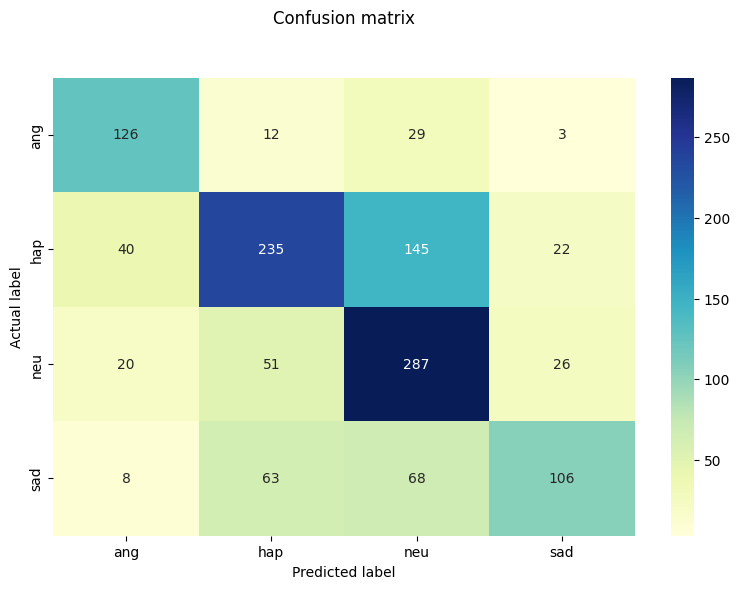

In [ ]:
confusion_matrix(y_test, y_preds_test)

In [ ]:
print(classification_report(y_test, y_preds_test))

              precision    recall  f1-score   support

           0       0.65      0.74      0.69       170
           1       0.65      0.53      0.59       442
           2       0.54      0.75      0.63       384
           3       0.68      0.43      0.53       245

    accuracy                           0.61      1241
   macro avg       0.63      0.61      0.61      1241
weighted avg       0.62      0.61      0.60      1241



### Evaluation on one example

In [ ]:
from datasets import load_dataset, Audio

dataset = load_dataset("Zahra99/IEMOCAP_Audio", split="session5")
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
sampling_rate = dataset.features["audio"].sampling_rate
audio_file = dataset[0]["audio"]["array"]

In [ ]:
dataset

Dataset({
    features: ['audio', 'label'],
    num_rows: 1241
})

In [ ]:
from transformers import pipeline

classifier = pipeline("audio-classification", model="Zahra99/whisper-tiny-finetuned-iemocap4")
classifier(audio_file)

[{'score': 0.9901930093765259, 'label': 'hap'},
 {'score': 0.004914671182632446, 'label': 'neu'},
 {'score': 0.0034157729241997004, 'label': 'sad'},
 {'score': 0.0014765338273718953, 'label': 'ang'}]

In [ ]:
dataset[0]

{'audio': {'path': 'Ses05F_script03_2_F000.wav',
  'array': array([-0.0020752 , -0.00167847, -0.00073242, ...,  0.00140381,
          0.00088501, -0.00024414]),
  'sampling_rate': 16000},
 'label': 2}

You can also manually replicate the results of the pipeline if you’d like:

In [ ]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("Zahra99/whisper-tiny-finetuned-iemocap4")
inputs = feature_extractor(dataset[0]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")

In [ ]:
inputs

{'input_features': tensor([[[-0.3743,  0.1444,  0.2690,  ..., -1.0283, -1.0283, -1.0283],
         [-0.0134,  0.0418,  0.2227,  ..., -1.0283, -1.0283, -1.0283],
         [-0.1586, -0.0401,  0.1494,  ..., -1.0283, -1.0283, -1.0283],
         ...,
         [-1.0283, -1.0283, -1.0283,  ..., -1.0283, -1.0283, -1.0283],
         [-1.0283, -1.0283, -1.0283,  ..., -1.0283, -1.0283, -1.0283],
         [-1.0283, -1.0283, -1.0283,  ..., -1.0283, -1.0283, -1.0283]]])}

In [ ]:
import torch
from transformers import AutoModelForAudioClassification

model = AutoModelForAudioClassification.from_pretrained("Zahra99/whisper-tiny-finetuned-iemocap4")
with torch.no_grad():
    logits = model(**inputs).logits

In [ ]:
logits

tensor([[-2.1983,  4.3099, -0.9957, -1.3596]])

In [ ]:
predicted_class_ids = torch.argmax(logits).item()
predicted_label = model.config.id2label[predicted_class_ids]
predicted_label

'hap'

## Whisper 2 (whisper-base)

### Load feature extractor

In [ ]:
from transformers import set_seed

set_seed(42)

In [ ]:
from transformers import AutoFeatureExtractor

model_checkpoint = "openai/whisper-base"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

In [ ]:
feature_extractor

WhisperFeatureExtractor {
  "chunk_length": 30,
  "feature_extractor_type": "WhisperFeatureExtractor",
  "feature_size": 80,
  "hop_length": 160,
  "n_fft": 400,
  "n_samples": 480000,
  "nb_max_frames": 3000,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "WhisperProcessor",
  "return_attention_mask": false,
  "sampling_rate": 16000
}

In [ ]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # there is no need for encoding label
    batch["label"] = batch["label"]
    return batch


In [ ]:
iemocap.column_names["train"]

['audio', 'label']

In [ ]:
encoded_iemocap_audio = iemocap.map(prepare_dataset, remove_columns="audio")

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

Map:   0%|          | 0/1031 [00:00<?, ? examples/s]

Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

In [ ]:
encoded_iemocap_audio

DatasetDict({
    train: Dataset({
        features: ['label', 'input_features'],
        num_rows: 3259
    })
    valid: Dataset({
        features: ['label', 'input_features'],
        num_rows: 1031
    })
    test: Dataset({
        features: ['label', 'input_features'],
        num_rows: 1241
    })
})

In [ ]:
encoded_iemocap_audio['train'][0]

{'label': 1,
 'input_features': [[0.4243883490562439,
   0.3921792507171631,
   0.2601354122161865,
   0.41285771131515503,
   0.3586781620979309,
   0.3181752562522888,
   0.48524487018585205,
   0.499445378780365,
   0.4349392056465149,
   0.5157755613327026,
   0.3697686791419983,
   0.26507794857025146,
   0.4284776449203491,
   0.26624369621276855,
   0.12277573347091675,
   0.32662320137023926,
   0.30575013160705566,
   0.3179091215133667,
   0.3678452968597412,
   0.35195255279541016,
   0.1549130082130432,
   0.2579531669616699,
   0.1983020305633545,
   0.02394801378250122,
   0.07177770137786865,
   0.3082776665687561,
   0.36633139848709106,
   0.29387420415878296,
   0.43945789337158203,
   0.222126305103302,
   0.38925302028656006,
   0.48330408334732056,
   0.2291894555091858,
   0.3428908586502075,
   0.4298374056816101,
   -0.19424951076507568,
   0.39165353775024414,
   0.35362011194229126,
   0.07067817449569702,
   0.3571345806121826,
   0.4166337847709656,
   0.334

In [ ]:
len(encoded_iemocap_audio['train'][0]['input_features'])

80

### Fine-Tunning Transformer

In [ ]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained( model_checkpoint, num_labels=num_labels, label2id=label2id, id2label=id2label)

Some weights of the model checkpoint at openai/whisper-base were not used when initializing WhisperForAudioClassification: ['model.decoder.layers.1.self_attn.out_proj.weight', 'model.decoder.layers.4.self_attn_layer_norm.weight', 'model.decoder.layers.5.self_attn.v_proj.bias', 'model.decoder.layers.1.fc2.weight', 'model.decoder.layers.5.encoder_attn_layer_norm.bias', 'model.decoder.layers.1.encoder_attn_layer_norm.weight', 'model.decoder.layers.4.self_attn_layer_norm.bias', 'model.decoder.layers.0.encoder_attn.q_proj.weight', 'model.decoder.layers.3.self_attn.q_proj.bias', 'model.decoder.layers.2.encoder_attn.v_proj.weight', 'model.decoder.layers.3.encoder_attn.q_proj.bias', 'model.decoder.layers.2.encoder_attn.out_proj.weight', 'model.decoder.layers.0.encoder_attn.v_proj.weight', 'model.decoder.layers.1.fc1.bias', 'model.decoder.layers.5.self_attn_layer_norm.weight', 'model.decoder.layers.5.self_attn.out_proj.weight', 'model.decoder.layers.2.final_layer_norm.bias', 'model.decoder.laye

In [ ]:
model

WhisperForAudioClassification(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 512)
    (layers): ModuleList(
      (0-5): 6 x WhisperEncoderLayer(
        (self_attn): WhisperAttention(
          (k_proj): Linear(in_features=512, out_features=512, bias=False)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affi

### Training the model

In [ ]:
batch_size = 4
# logging_steps = len(encoded_iemocap_audio["train"]) // batch_size
training_args = TrainingArguments(output_dir=f"{model_checkpoint}-finetuned-iemocap2",
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  learning_rate=3e-5,
                                  per_device_train_batch_size=batch_size,
                                  gradient_accumulation_steps=1,
                                  per_device_eval_batch_size=batch_size,
                                  num_train_epochs=2,
                                  warmup_ratio=0.1,
                                  logging_steps=10,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="accuracy",
                                  push_to_hub=True,
                                  hub_private_repo=True,
                                  report_to = 'wandb',
                                  run_name = 'Whisper-base-fine-tuning-base')

In [ ]:
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=encoded_iemocap_audio["train"],
                  eval_dataset=encoded_iemocap_audio["valid"],
                  tokenizer=feature_extractor,
                  compute_metrics=compute_metrics)

Cloning https://huggingface.co/Zahra99/whisper-base-finetuned-iemocap2 into local empty directory.


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
trainer.train()

wandb: Currently logged in as: zdehghanitafti78 (affective-computing). Use `wandb login --relogin` to force relogin


In [ ]:
!nvidia-smi

<img style="float: left;" src='https://drive.google.com/uc?id=15hxkL2mXXDc81Snc4PAQiOuxFEqfEkXL' width="500" height="300">
<!-- <br> -->
<img style="float: right;" src='https://drive.google.com/uc?id=1MbWA0G6NNe8ly7XBziM57lxWZqJ844G_' width="500" height="300">
<!-- <br> -->
<img src='https://drive.google.com/uc?id=19P_T1kmtiBfasmNySqRQnKLkZzBMg7ai' width="500" height="300">

In [ ]:
trainer.push_to_hub("")

### Evaluation on the Test set

In [ ]:
preds_output_test = trainer.predict(encoded_iemocap_audio["test"])

In [ ]:
preds_output_test.metrics

{'test_loss': 1.5485539436340332,
 'test_accuracy': 0.6075745366639806,
 'test_f1': 0.6019505566038218,
 'test_runtime': 222.8484,
 'test_samples_per_second': 5.569,
 'test_steps_per_second': 0.7}

In [ ]:
y_test = np.array(encoded_iemocap_audio["test"]["label"])

In [ ]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

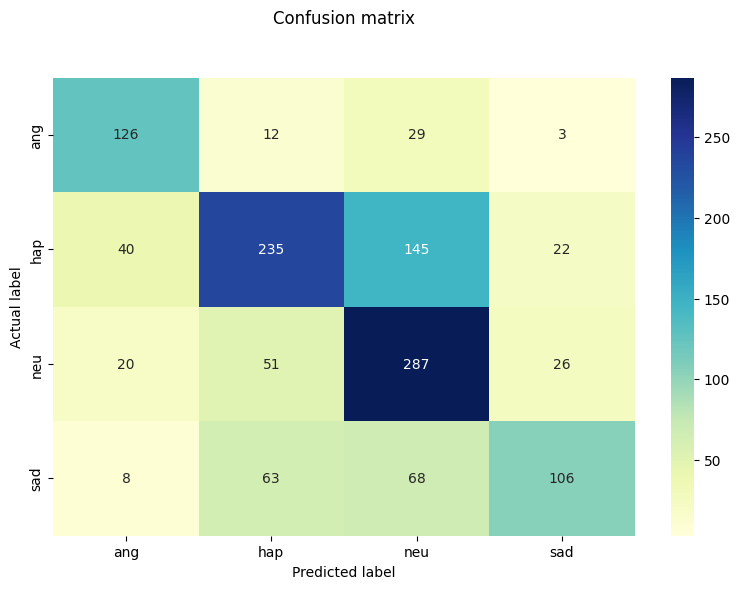

In [ ]:
confusion_matrix(y_test, y_preds_test)

In [ ]:
print(classification_report(y_test, y_preds_test))

              precision    recall  f1-score   support

           0       0.65      0.74      0.69       170
           1       0.65      0.53      0.59       442
           2       0.54      0.75      0.63       384
           3       0.68      0.43      0.53       245

    accuracy                           0.61      1241
   macro avg       0.63      0.61      0.61      1241
weighted avg       0.62      0.61      0.60      1241



### Evaluation on one example

In [ ]:
from datasets import load_dataset, Audio

dataset = load_dataset("Zahra99/IEMOCAP_Audio", split="session5")
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
sampling_rate = dataset.features["audio"].sampling_rate
audio_file = dataset[0]["audio"]["array"]

In [ ]:
dataset

Dataset({
    features: ['audio', 'label'],
    num_rows: 1241
})

In [ ]:
from transformers import pipeline

classifier = pipeline("audio-classification", model="")
classifier(audio_file)

[{'score': 0.9901930093765259, 'label': 'hap'},
 {'score': 0.004914671182632446, 'label': 'neu'},
 {'score': 0.0034157729241997004, 'label': 'sad'},
 {'score': 0.0014765338273718953, 'label': 'ang'}]

In [ ]:
dataset[0]

{'audio': {'path': 'Ses05F_script03_2_F000.wav',
  'array': array([-0.0020752 , -0.00167847, -0.00073242, ...,  0.00140381,
          0.00088501, -0.00024414]),
  'sampling_rate': 16000},
 'label': 2}

You can also manually replicate the results of the pipeline if you’d like:

In [ ]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("")
inputs = feature_extractor(dataset[0]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")

In [ ]:
inputs

{'input_features': tensor([[[-0.3743,  0.1444,  0.2690,  ..., -1.0283, -1.0283, -1.0283],
         [-0.0134,  0.0418,  0.2227,  ..., -1.0283, -1.0283, -1.0283],
         [-0.1586, -0.0401,  0.1494,  ..., -1.0283, -1.0283, -1.0283],
         ...,
         [-1.0283, -1.0283, -1.0283,  ..., -1.0283, -1.0283, -1.0283],
         [-1.0283, -1.0283, -1.0283,  ..., -1.0283, -1.0283, -1.0283],
         [-1.0283, -1.0283, -1.0283,  ..., -1.0283, -1.0283, -1.0283]]])}

In [ ]:
import torch
from transformers import AutoModelForAudioClassification

model = AutoModelForAudioClassification.from_pretrained("")
with torch.no_grad():
    logits = model(**inputs).logits

In [ ]:
logits

tensor([[-2.1983,  4.3099, -0.9957, -1.3596]])

In [ ]:
predicted_class_ids = torch.argmax(logits).item()
predicted_label = model.config.id2label[predicted_class_ids]
predicted_label

'hap'